In [4]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

pd.set_option('max_colwidth', 1000)

import seaborn as sns

In [6]:
import pandas as pd
from collections import defaultdict

from webnlg_corpus import webnlg

corpus = webnlg.load('webnlg_challenge_2017')

train_dev = corpus.subset(datasets=['train', 'dev'])
test = corpus.subset(datasets=['test'])

In [12]:
train_dev.sample(seed=123)

Triple info: Category=Building eid=Id19 idx=dev_Building_3_Id19

	Modified Triples:

Alan_B._Miller_Hall | owner | College_of_William_&_Mary
Alan_B._Miller_Hall | location | Williamsburg,_Virginia
Alan_B._Miller_Hall | buildingStartDate | "30 March 2007"


	Lexicalizations:

Alan B. Miller Hall, the building of which began 30 March, 2007, is located in Williamsburg, Virginia and owned by the College of William and Mary.


Alan B. Miller Hall's building, started on 30th March 2007, is located in Williamsburg, Virginia, and owned by the College of William and Mary.


The Alan B. Miller Hall, owned by The College of William and Mary, is in Williamsburg, Virginia and was opened on the 30th March 2007.


In [102]:
statistics = defaultdict(list)
idx = ['train_dev', 'test']

for ds in [train_dev, test]:
    
    statistics['n_entries'].append(len(ds.edf)) # number of entries
    statistics['n_distinct_triples'].append(ds.mdf.text.nunique()) # number of distinct triples
    statistics['n_distinct_lexes'].append(ds.ldf.text.nunique()) # number of distinct generated texts
    statistics['n_lexes'].append(len(ds.ldf)) # number of generated texts
    statistics['n_triples'].append(len(ds.mdf)) # number of triples -> each entry can have up to 7 triples
    statistics['text_length_mean'].append(ds.ldf.text.str.len().mean())
    statistics['n_unique_subject'].append(ds.mdf.subject.nunique()),
    statistics['n_unique_predicate'].append(ds.mdf.predicate.nunique()),
    statistics['n_unique_object'].append(ds.mdf.object.nunique())
    

pd.DataFrame(statistics, index=idx)

,n_entries,n_distinct_triples,n_distinct_lexes,n_lexes,n_triples,text_length_mean,n_unique_subject,n_unique_predicate,n_unique_object
train_dev,7812,2131,20308,20370,23021,117.367354,434,246,1642
test,1862,2331,4922,4928,5378,114.805195,575,300,1888


In [51]:
# unseen categories

set(test.edf.category.unique()) - set(train_dev.edf.category.unique())

{'Artist', 'Athlete', 'CelestialBody', 'MeanOfTransportation', 'Politician'}

## Are entries with shared triples lexicalized the same way?

Remember that the same triple can appear in more than one entry.

There are some patterns...

In [84]:
def mtriples_with_generated_lexes(ds):
    
    df = pd.merge(ds.mdf, ds.ldf, on='idx', suffixes=('_mdf', '_ldf'))
    
    # groups by triple and for each triple generates a list of lexicalizations
    ddf = df.groupby('text_mdf').text_ldf.apply(list).to_frame()
    # adds a column with the number of lexicalizations
    ddf['size'] = ddf.text_ldf.apply(len)
    
    return ddf

# prints triple and its lexicalizations
def print_mtriple_with_generated_lexes(mtriple):
    
    print("triple: ", mtriple.name, '\n')
    for text in mtriple.text_ldf:
        print("lexicalization: ", text, '\n')

### train_dev

In [93]:
mtriples_w_lexes_train = mtriples_with_generated_lexes(train_dev)

mtriples_w_lexes_train['size'].describe()

count    2131.000000
mean       28.432191
std        34.977128
min         1.000000
25%         6.000000
50%        17.000000
75%        36.000000
max       319.000000
Name: size, dtype: float64

In [85]:
# some examples of triples that are lexicalizad in more than one way
mtriples_w_lexes_train_size_lt_5 = mtriples_w_lexes_train[mtriples_w_lexes_train['size'] < 5]

print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[0, :])

triple:  11_Diagonal_Street | floorArea | 1200 (square metres) 

lexicalization:  11 Diagonal Street has a floor area of 1200 square metres. 

lexicalization:  The architect of 11 Diagonal Street is Helmut Jahn and it was completed in 1983. It has 20 floors and a floor area of 1200 square metres. 

lexicalization:  11 Diagonal Street was designed by Helmut Jahn and was completed in 1983. It has 20 floors and an area of 1200 square metres. 

lexicalization:  Helmut Jahn was the architect of 11 Diagonal Street which was completed in 1983 with 20 floors and a total floor area of 1200 square metres. 



In [86]:
print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[1, :])

triple:  11_Diagonal_Street | location | Johannesburg 

lexicalization:  11 Diagonal Street is in Johannesburg. 

lexicalization:  11 Diagonal Street is located in Johannesburg. 



In [87]:
print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[2, :])

triple:  1634:_The_Bavarian_Crisis | language | English_language 

lexicalization:  1634: The Bavarian Crisis is written in English. 

lexicalization:  1634: The Bavarian Crisis was written by Eric Flint in English and was preceded by Grantville Gazette III. 

lexicalization:  Eric Flint wrote the book 1634: The Bavarian Crisis. It is the sequel to Grantville Gazette III. 

lexicalization:  1634: The Bavarian Crisis is written in English and the sequel to Grantville Gazette III written by Eric Flint. 



# And what about lexicalizations for same predicates?

In [100]:
def m_predicates_with_generated_lexes(ds):
    
    df = pd.merge(ds.mdf, ds.ldf, on='idx', suffixes=('_mdf', '_ldf'))
    
    ddf = df.groupby('predicate').text_ldf.apply(list).to_frame()
    ddf['size'] = ddf.text_ldf.apply(len)
    
    return ddf

def print_m_predicate_with_generated_lexes(mtriple):
    
    print("predicate: ", mtriple.name, '\n')
    for text in sorted(mtriple.text_ldf):
        print("lexicalization: ", text, '\n')

In [94]:
m_predicates_w_lexes_train = m_predicates_with_generated_lexes(train_dev)

m_predicates_w_lexes_train['size'].describe()

count     246.000000
mean      246.296748
std       597.935924
min         1.000000
25%        20.000000
50%        67.000000
75%       219.500000
max      6345.000000
Name: size, dtype: float64

In [95]:
m_predicates_w_lexes_train.nlargest(10, 'size').reset_index()[['predicate', 'size']]

,predicate,size
0,country,6345
1,location,4046
2,leaderName,3537
3,ingredient,1930
4,region,1673
5,isPartOf,1640
6,language,1596
7,ethnicGroup,1524
8,birthPlace,1281
9,club,1145


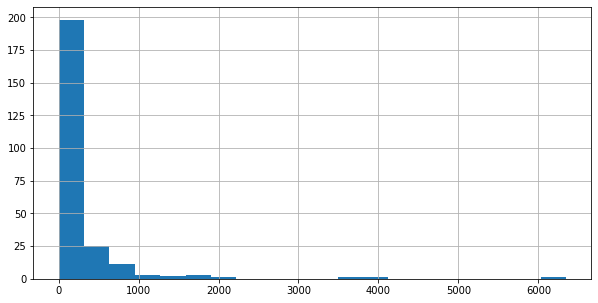

In [96]:
m_predicates_w_lexes_train['size'].hist(bins=20, figsize=(10, 5))

In [101]:
m_predicates_w_lexes_train_size_lt_10 = m_predicates_w_lexes_train[m_predicates_w_lexes_train['size'] < 10]

print_m_predicate_with_generated_lexes(m_predicates_w_lexes_train_size_lt_10.sample().iloc[0, :])

predicate:  placeOfDeath 

lexicalization:  Alfred Giles was born in England and died in Kendall County, Texas. He designed the Asher and Mary Isabelle Richardson House . 

lexicalization:  Alfred Giles was the architect of Asher and Mary Isabelle Richardson House and died in Kendall County, Texas. 

lexicalization:  Alfred Giles, architect of The Asher and Mary Isabelle Richardson House died in Kendall County, Texas. 

lexicalization:  Asher and Mary Isabelle Richardson House was designed by architect Alfred Giles who died in Kendall County, Texas. 

lexicalization:  The architect Alfred Giles died in Kendall County Texas. 

lexicalization:  The architect Alfred Giles died in Kendall County, Texas. 

lexicalization:  The architect Alfred Giles was born in England and he died in Kendall County, Texas. He was the architect of Asher and Mary Isabelle Richardson House. 

lexicalization:  The architect of Asher and Mary Isabelle Richardson House Alfred Giles was born in England and died in

## Most frequent subjects, predicates, objects

in relation to amount of entries in which they occur, not the amount of lexicalizations where they appear(remember that an entry can have more than one lexicalization)

In [106]:
def most_frequent(ds, type_, n=5):
    
    if type_ == 'subject':
        return ds.mdf.subject.value_counts().nlargest(n)
    if type_ == 'object':
        return ds.mdf.object.value_counts().nlargest(n)
    if type_ == 'predicate':
        return ds.mdf.predicate.value_counts().nlargest(n)

### train_dev

In [107]:
most_frequent(train_dev, 'subject')

United_States                      760
Acharya_Institute_of_Technology    539
Alan_Shepard                       478
Elliot_See                         474
Alan_Bean                          410
Name: subject, dtype: int64

In [108]:
most_frequent(train_dev, 'object')

United_States       944
English_language    294
Indonesia           185
Spain               169
Italy               142
Name: object, dtype: int64

In [109]:
most_frequent(train_dev, 'predicate')

country       2409
location      1537
leaderName    1385
ingredient     738
isPartOf       641
Name: predicate, dtype: int64

## Vocabulary distribution

### m_subject

In [110]:
m_subject_vc = train_dev.mdf.subject.value_counts()

m_subject_vc.describe(percentiles=[.5, .75, .9, .99])

count    434.000000
mean      53.043779
std       79.166678
min        1.000000
50%       20.000000
75%       79.750000
90%      124.000000
99%      409.670000
max      760.000000
Name: subject, dtype: float64

* 50% dos m_subject ocorrem 20 ou menos vezes
* 50% dos m_subject ocorrem 21 ou mais vezes

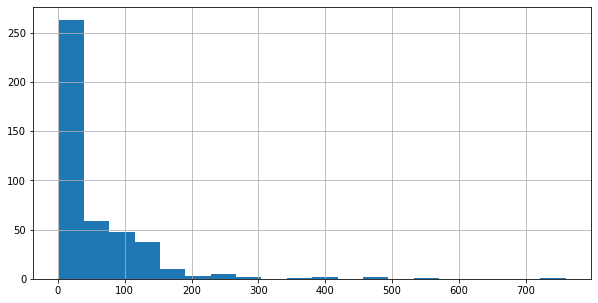

In [112]:
m_subject_vc.hist(bins=20, figsize=(10, 5))

### m_predicate

In [113]:
m_predicate_vc = train_dev.mdf.predicate.value_counts()

m_predicate_vc.describe(percentiles=[.5, .75, .9, .99])

count     246.000000
mean       93.581301
std       228.610263
min         1.000000
50%        25.000000
75%        80.000000
90%       228.000000
99%      1093.850000
max      2409.000000
Name: predicate, dtype: float64

* 50% dos m_predicate ocorrem 25 ou menos vezes
* 50% dos m_predicate ocorrem 26 ou mais vezes

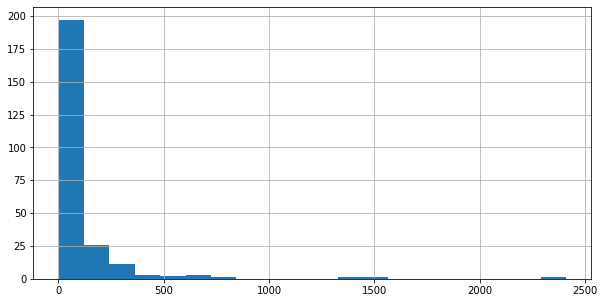

In [114]:
m_predicate_vc.hist(bins=20, figsize=(10, 5))

### m_object

In [50]:
m_object_vc = train_dev.mdf.object.value_counts()

m_object_vc.describe(percentiles=[.5, .75, .9, .99])

count    1642.000000
mean       14.020097
std        30.023659
min         1.000000
50%         7.000000
75%        16.000000
90%        31.000000
99%        93.180000
max       944.000000
Name: object, dtype: float64

* 50% dos m_object ocorrem 7 ou menos vezes
* 50% dos m_object ocorrem 8 ou mais vezes

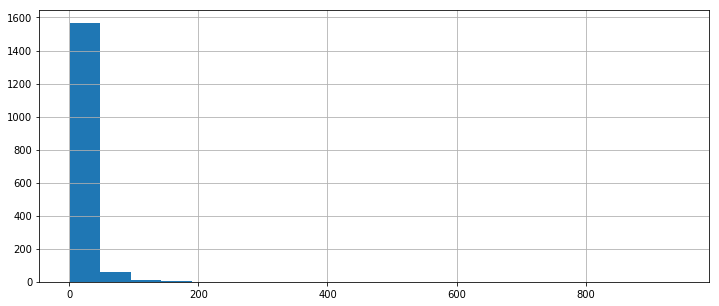

In [51]:
m_object_vc.hist(bins=20, figsize=(12, 5))